# IMPORT LIBRARIES

In [1]:
import requests
import zipfile
import os
import tensorflow as tf
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import os
import math
import dill

from pathlib import Path
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from tqdm import tqdm
from PIL import Image

# SETUP CONSTANTS

* Pada bagian ini, kita akan mendefinisikan beberapa konstanta yang penting untuk proses pemrosesan data dan pelatihan model.
* Konstanta ini akan membantu kita dalam mengatur jalur folder dataset, pola ekstensi file gambar yang akan dikumpulkan, dan folder mana saja yang harus diakses.
* Nantinya, konstanta-konstanta ini akan digunakan di berbagai bagian kode.

## function

In [2]:
def download_and_extract_zip(url, save_dir, extract_dir, filename="dataset.zip", chunk_size=1024, is_file_removed=True):
    """
    Mengunduh file zip dari URL dan mengekstraknya ke direktori tertentu hanya jika belum ada hasil ekstrak.

    Args:
        url (str): URL file zip yang akan diunduh.
        save_dir (str): Direktori tempat menyimpan file zip.
        extract_dir (str): Direktori tujuan untuk mengekstrak file zip.
        filename (str, optional): Nama file zip yang disimpan. Default "dataset.zip".
        chunk_size (int, optional): Ukuran chunk untuk unduhan. Default 1024 (1 KB).
        is_file_removed (bool, optional): Hapus file zip setelah ekstraksi. Default True.

    Raises:
        Exception: Jika ada error saat mengunduh atau mengekstrak file.
    """
    # Memastikan direktori penyimpanan dan ekstrak ada
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(extract_dir, exist_ok=True)

    # Path file zip yang akan disimpan
    zipfile_path = os.path.join(save_dir, filename)

    # Pengecekan apakah direktori ekstrak sudah berisi file
    if os.listdir(extract_dir):  
        print("File sudah diekstrak sebelumnya. Tidak ada tindakan lebih lanjut.")
        return  # Keluar dari fungsi jika file sudah diekstrak

    # Jika belum ada hasil ekstrak, lanjutkan unduhan
    try:
        if not os.path.exists(zipfile_path):
            # Mengunduh file dengan progress bar
            response = requests.get(url, stream=True, timeout=10)
            response.raise_for_status()  # Cek jika ada error HTTP

            total_size = int(response.headers.get('content-length', 0))
            with open(zipfile_path, "wb") as file, tqdm(
                    desc=f"Downloading {filename}",
                    total=total_size,
                    unit='B', unit_scale=True, unit_divisor=1024,
            ) as bar:
                for chunk in response.iter_content(chunk_size=chunk_size):
                    file.write(chunk)
                    bar.update(len(chunk))

            print(f"\nFile downloaded to {zipfile_path}")
        else:
            print(f"{filename} sudah ada di {zipfile_path}.")

        # Mengekstrak file zip jika belum ada hasil ekstrak
        with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
            print(f"Files extracted to {extract_dir}")

    except requests.exceptions.RequestException as e:
        raise Exception(f"Error downloading the file: {e}")

    except zipfile.BadZipFile:
        raise Exception("Error: The downloaded file is not a valid zip file.")

    except Exception as e:
        raise Exception(f"An unexpected error occurred: {e}")

    finally:
        # Menghapus file zip yang sudah diekstrak jika is_file_removed=True
        if os.path.exists(zipfile_path) and is_file_removed:
            os.remove(zipfile_path)
            print("Downloaded zip file removed.")

In [3]:
def custom_title_print(title, n_strip=80):
    """
    Mencetak judul yang disesuaikan dengan garis pembatas di atas dan di bawah judul.

    Args:
        title (str): Judul yang ingin ditampilkan.
        n_strip (int): Jumlah karakter '=' untuk membuat garis pembatas. Default adalah 80.

    Returns:
        None
    """
    print('=' * n_strip)
    print(f' {title.upper()} '.center(n_strip, '='))
    print('=' * n_strip)

In [4]:
def collect_images_with_regex_and_count(path, folders, extensions_pattern):
    """
    Mengumpulkan jalur gambar dari beberapa folder yang ada dalam path utama dengan memfilter gambar
    berdasarkan ekstensi menggunakan regex. Fungsi ini mengembalikan dictionary dengan kunci berupa
    nama folder dan nilai berupa daftar jalur file gambar.

    Args:
        path (str): Jalur utama folder yang berisi sub-folder data gambar.
        folders (list): Daftar nama folder yang akan di-scan untuk gambar.
        extensions_pattern (str): Pola regex untuk mencocokkan ekstensi file gambar (contoh: r'\.(jpg|png|jpeg)$').

    Returns:
        dict: Dictionary dengan kunci berupa nama folder dan nilai berupa daftar jalur file gambar yang sesuai dengan pola.
    """

    try:
        image_paths = {folder: [] for folder in folders}   # Membuat dictionary kosong untuk menyimpan jalur gambar
        pattern = re.compile(extensions_pattern, re.IGNORECASE) # Membuat pola regex untuk mencocokkan ekstensi gambar dengan ignore case

        for folder in folders:
            folder_path = Path(path) / folder # Mendapatkan jalur folder

            for file_path in tqdm(folder_path.rglob("*"), desc=f"Collecting from {folder}", unit=" paths"):
                if pattern.search(file_path.suffix):  # Memeriksa apakah ekstensi file cocok dengan pola
                    image_paths[folder].append(file_path)  # Menambahkan jalur file ke dalam daftar jika cocok

        return image_paths  # Mengembalikan dictionary jalur gambar

    except Exception as e:
        print(f"No classes are retrieved from directory validation")
        return {}

In [5]:
def get_random_images(image_paths, num_samples, seed=42):
    """
    Mengambil sejumlah gambar secara acak dari daftar jalur gambar.

    Args:
        image_paths (list): Daftar jalur gambar.
        num_samples (int): Jumlah gambar yang ingin diambil. Jika None, semua gambar akan dipilih.
        seed (int): Seed untuk mengontrol hasil pengambilan acak agar hasilnya bisa direproduksi. Default adalah 42.

    Returns:
        list: Daftar jalur gambar yang dipilih secara acak.
    """
    random.seed(seed)
    return random.sample(image_paths, min(len(image_paths) if num_samples is None else num_samples, len(image_paths)))


In [6]:
def collect_and_combine_images(classes, train_path=None, valid_path=None, pattern_regex=r"\.(jpe?g)$", num_images_per_class=None, seed=42):
    """
    Mengumpulkan dan menggabungkan gambar dari folder training dan validation, lalu mengambil sejumlah gambar secara acak dari setiap kelas.

    Args:
        classes (list): Daftar kelas (nama folder) yang ingin diproses.
        train_path (str): Jalur utama folder training yang berisi sub-folder data gambar.
        valid_path (str): Jalur utama folder validation yang berisi sub-folder data gambar.
        pattern_regex (str): Pola regex untuk mencocokkan ekstensi file gambar (contoh: r'\.(jpg|png|jpeg)$').
        num_images_per_class (dict): Dictionary berisi jumlah gambar yang ingin diambil untuk setiap kelas. Jika None, semua gambar akan diambil.
        seed (int): Seed untuk pengambilan gambar secara acak. Default adalah 42.

    Returns:
        list: Daftar gabungan jalur gambar dari folder training dan validation yang diambil secara acak.
    """

    try:
        def process_class(cls):
            # Menggabungkan gambar dari training dan validation untuk setiap kelas
            all_train_images = train_images_paths.get(cls, [])
            all_valid_images = valid_images_paths.get(cls, [])
            all_combined_images = all_train_images + all_valid_images

            # Mengambil sejumlah gambar acak dari gambar gabungan
            return get_random_images(
                image_paths=all_combined_images,
                num_samples=None if num_images_per_class is None else num_images_per_class.get(cls, len(all_combined_images)),
                seed=seed
            )

        # Mencetak judul untuk proses pengumpulan gambar dari data training
        custom_title_print(f"COLLECT {classes} FROM TRAINING DATA")
        train_images_paths = collect_images_with_regex_and_count(train_path, classes, pattern_regex)
        print()

        # Mencetak judul untuk proses pengumpulan gambar dari data validation
        custom_title_print(f"COLLECT {classes} FROM VALIDATION DATA")
        valid_images_paths = collect_images_with_regex_and_count(valid_path, classes, pattern_regex)
        print()
        print()

        # Mencetak judul untuk proses penggabungan gambar dari training dan validation
        custom_title_print(f"COMBINING {classes} FROM TRAINING AND VALIDATION DATA")

        random_images = {}

        # Menggunakan ThreadPoolExecutor untuk mempercepat proses pengambilan gambar dari setiap kelas secara paralel
        with ThreadPoolExecutor() as executor:
            results = executor.map(process_class, classes)

        # Menyimpan hasil gambar acak untuk setiap kelas ke dalam dictionary
        for cls, images in zip(classes, results):
            random_images[cls] = images
            print(f"Total {cls} taken: {len(random_images[cls])}")

        # Menggabungkan semua jalur gambar dari semua kelas
        all_images_paths = sum(random_images.values(), [])
        all_images_paths = [str(path) for path in all_images_paths]
        print(f"Total images taken: {len(all_images_paths)}".upper())

        return all_images_paths

    except Exception as e:
        print(f"Error: {e}")
        return []

In [7]:
def save_object(file_path, obj):
    """
    Menyimpan objek ke dalam file menggunakan serialisasi dengan dill.

    Args:
        file_path (str): Jalur file tempat objek akan disimpan.
        obj (object): Objek yang akan disimpan, bisa berupa list, dictionary, atau objek Python lainnya.

    Returns:
        None
    """

    try:
        if os.path.exists(file_path): # Memeriksa apakah file sudah ada
            print(f"File '{file_path}' already exists. Skipping saving.")
            return # Jika sudah ada, tidak perlu menyimpan lagi

        dir_path = os.path.dirname(file_path)  # Mendapatkan jalur direktori dari file
        os.makedirs(dir_path, exist_ok=True) # Membuat direktori jika belum ada

        with open(file_path, 'wb') as file_obj: # Membuka file dalam mode write-binary
            dill.dump(obj, file_obj) # Menyimpan objek menggunakan dill
        print(f"Object saved to {file_path}")

    except Exception as e:
        print(f"Error saving object: {e}")

## main program

In [8]:
# ==========================================================================================
# ==================================== PARENT PATH CONSTANT ================================
# ==========================================================================================
PARENT_DATASET_PATH = ".."
DATA_DOWNLOAD_URL = "https://huggingface.co/datasets/garythung/trashnet/resolve/main/dataset-resized.zip"
ARTIFACTS_PATH = os.path.join(PARENT_DATASET_PATH, "artifacts")
DATA_INGESTION_ARTIFACTS_DIR_PATH = os.path.join(ARTIFACTS_PATH, "data_ingestion")
DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH = os.path.join(ARTIFACTS_PATH, "data_transformation")
OBJECT_PATH = os.path.join(ARTIFACTS_PATH, "objects")
REPORT_PATH = os.path.join(ARTIFACTS_PATH, "reports")

# ==========================================================================================
# ==================================== DATA PATH CONSTANT ==================================
# ==========================================================================================
TRAIN_PATH = os.path.join(DATA_INGESTION_ARTIFACTS_DIR_PATH, "dataset-resized")
TRAIN_TFRECOARD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "train_trashnet.tfrecord")
VALID_TFRECORD_PATH = os.path.join(DATA_TRANSFORMATION_ARTIFACTS_DIR_PATH, "valid_trashnet.tfrecord")



# ==========================================================================================
# =============================== OBJECT PATH CONSTANT =====================================
# ==========================================================================================
LABEL_LIST_PATH = os.path.join(OBJECT_PATH, "label_list.pkl")
CLASS_WEIGHTS_PATH = os.path.join(OBJECT_PATH, "class_weights.pkl")


# ==========================================================================================
# ======================================== CONSTANT ========================================
# ==========================================================================================
PATTERN_IMAGE_EXT_REGEX = r"\.(jpe?g|png)$"
LABEL_LIST = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
SPLIT_RATIO = (0.9, 0.1)
IMAGE_SIZE = (224, 224)

### DATA INGESTION

In [9]:
download_and_extract_zip(
    url=DATA_DOWNLOAD_URL, 
    save_dir=DATA_INGESTION_ARTIFACTS_DIR_PATH, 
    extract_dir=DATA_INGESTION_ARTIFACTS_DIR_PATH,
    is_file_removed=False
)


File downloaded to ..\artifacts\data_ingestion\dataset.zip
Files extracted to ..\artifacts\data_ingestion


#### Menyimpan dan Menggabungkan Gambar dari Folder Training dan Validation

* Pada bagian ini, kita menggunakan fungsi `collect_and_combine_images` untuk mengumpulkan dan menggabungkan gambar, dari folder training dan validation berdasarkan kelas yang ada di `NUM_IMAGES_PER_CLASS`. Fungsi ini akan memilih gambar secara acak sesuai dengan jumlah yang telah ditentukan untuk setiap kelas.
* Setelah proses pengumpulan gambar selesai, semua jalur gambar disimpan dalam variabel `ALL_IMAGES_PATHS` untuk digunakan pada proses selanjutnya.

In [10]:
ALL_IMAGES_PATHS = collect_and_combine_images(
    classes = LABEL_LIST,
    train_path  = TRAIN_PATH,
    pattern_regex = PATTERN_IMAGE_EXT_REGEX,
)

 COLLECT ['CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC', 'TRASH'] FROM TRAINING DATA 



 COLLECT ['CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC', 'TRASH'] FROM VALIDATION DATA 
No classes are retrieved from directory validation


 COMBINING ['CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC', 'TRASH'] FROM TRAINING AND VALIDATION DATA 
Total cardboard taken: 403
Total glass taken: 501
Total metal taken: 410
Total paper taken: 594
Total plastic taken: 482
Total trash taken: 137
TOTAL IMAGES TAKEN: 2527


#### Menyimpan Label Encoding

* Selain itu, kita juga menggunakan fungsi `save_object` untuk menyimpan objek ke dalam file.
* Pada contoh ini, kita menyimpan daftar kelas yang digunakan untuk encoding label di path yang telah didefinisikan sebelumnya, yaitu `LABEL_LIST_PATH`.
* Objek ini disimpan dalam format serial menggunakan `dill` agar dapat dimuat kembali di lain waktu.

In [11]:
save_object(
    file_path=LABEL_LIST_PATH,
    obj=LABEL_LIST
)

Object saved to ..\artifacts\objects\label_list.pkl


# PREPARING DATA WORKFLOW

## Step 1. Eksplorasi Data

### function

In [12]:
class FilePathInfo:
    """
    Kelas FilePathInfo digunakan untuk menampilkan informasi detail tentang jalur file pada dataset, termasuk
    nama file, ekstensi, ukuran file, dan label (jika ada). Kelas ini juga mendukung penggunaan unit ukuran
    file yang berbeda seperti 'bytes', 'kb', 'mb', dan 'gb'.

    Args:
        unit_file_size (str, optional): Unit untuk menampilkan ukuran file ('bytes', 'kb', 'mb', 'gb'). Default adalah 'bytes'.
    """

    def __init__(self, unit_file_size='bytes'):
        """
        Inisialisasi kelas FilePathInfo dengan unit ukuran file yang diberikan.

        Args:
            unit_file_size (str, optional): Unit untuk menampilkan ukuran file ('bytes', 'kb', 'mb', 'gb'). Default adalah 'bytes'.
        """
        self.unit_file_size = unit_file_size.lower()
        self.units = ['bytes', 'kb', 'mb', 'gb']
        if self.unit_file_size not in self.units:
            raise ValueError(f"Invalid unit. Choose from {self.units}.")

    def show_train_files_path_info(self, files_path_data, is_labeled=True, is_random=False):
        """
        Menampilkan informasi detail tentang jalur file pada dataset training.

        Args:
            files_path_data (tf.data.Dataset): Dataset yang berisi jalur file.
            is_labeled (bool, optional): Menunjukkan apakah dataset memiliki label. Default adalah True.
            is_random (bool, optional): Menunjukkan apakah dataset perlu diacak sebelum ditampilkan. Default adalah False.

        Returns:
            int: Indeks label pada jalur file, jika dataset memiliki label.
        """
        files_path_data_plot = self._get_files_path_data_plot(files_path_data, is_random)
        label_index = self._display_path_info(files_path_data_plot, is_labeled)
        return label_index

    def show_test_files_path_info(self, files_path_data, is_labeled=False, is_random=False):
        """
        Menampilkan informasi detail tentang jalur file pada dataset testing.

        Args:
            files_path_data (tf.data.Dataset): Dataset yang berisi jalur file.
            is_random (bool, optional): Menunjukkan apakah dataset perlu diacak sebelum ditampilkan. Default adalah False.
        """
        files_path_data_plot = self._get_files_path_data_plot(files_path_data, is_random)
        self._display_path_info(files_path_data_plot, is_labeled)

    def _get_files_path_data_plot(self, files_path_data, is_random):
        """
        Mengambil subset dari dataset jalur file, dengan opsi pengacakan.

        Args:
            files_path_data (tf.data.Dataset): Dataset yang berisi jalur file.
            is_random (bool): Apakah dataset perlu diacak.

        Returns:
            tf.data.Dataset: Subset dari dataset yang dipilih.
        """
        if is_random:
            return files_path_data.shuffle(buffer_size=files_path_data.cardinality().numpy()).take(1)
        else:
            return files_path_data.take(1)

    def _display_path_info(self, files_path_data_plot, is_labeled):
        """
        Menampilkan informasi lengkap dari jalur file yang dipilih, termasuk nama file, ekstensi, ukuran, dan label jika ada.

        Args:
            files_path_data_plot (tf.data.Dataset): Subset dari dataset yang akan ditampilkan.
            is_labeled (bool): Menunjukkan apakah dataset memiliki label.

        Returns:
            int: Indeks label pada jalur file jika dataset berlabel.
        """
        for file_path in files_path_data_plot:
            custom_title_print(' PATH INFO ')
            print(f'File Path: {file_path.numpy().decode("utf-8")}')
            print()

            split_file_path = self._split_file_path(file_path)
            self._display_split_file_path(split_file_path)

            if is_labeled:
                kind_data = split_file_path[-3].numpy().decode('utf-8')
                index_label = self._display_kind_data_info(split_file_path, kind_data)
                self._display_file_info(split_file_path, file_path)
                return index_label
            else:
                self._display_file_info(split_file_path, file_path)

    def _split_file_path(self, file_path):
        """
        Memecah jalur file menjadi bagian-bagian menggunakan separator file system.

        Args:
            file_path (tf.Tensor): Jalur file.

        Returns:
            tf.Tensor: Jalur file yang sudah dipecah.
        """
        return tf.strings.split(file_path, os.path.sep)

    def _display_split_file_path(self, split_file_path):
        """
        Menampilkan jalur file yang sudah dipecah dan indeks dari setiap bagian.

        Args:
            split_file_path (tf.Tensor): Jalur file yang sudah dipecah.
        """
        custom_title_print(' SPLIT FILE PATH ')
        print(f'Split File Path: {split_file_path}')
        print()

        custom_title_print(' INDEXED PATH ')
        result = {value: f'Index -> {index}' for index, value in enumerate(split_file_path.numpy())}
        for key, value in result.items():
            print(f'{value}: {key}')
        print()

    def _display_kind_data_info(self, split_file_path, kind_data):
        """
        Menampilkan indeks dan label dari data berdasarkan jenisnya.

        Args:
            split_file_path (tf.Tensor): Jalur file yang sudah dipecah.
            kind_data (str): Jenis data yang ada di jalur file.

        Returns:
            int: Indeks label pada jalur file.
        """
        custom_title_print(f' KIND DATA INDEX {kind_data} ')
        index = tf.where(tf.equal(split_file_path, kind_data))[0][0]
        print(f'Index of "{kind_data}": {index}')
        print()

        index_label = index + 1
        custom_title_print(' INDEX LABEL ')
        print(f'Index Label: {index_label}')
        print()

        custom_title_print(' LABEL ')
        print(f'Label: {split_file_path[index_label]}')
        print()

        return index_label.numpy()

    def _display_file_info(self, split_file_path, file_path):
        """
        Menampilkan informasi detail tentang file seperti nama, ekstensi, dan ukuran file.

        Args:
            split_file_path (tf.Tensor): Jalur file yang sudah dipecah.
            file_path (tf.Tensor): Jalur file.
        """
        file_name = split_file_path[-1].numpy().decode('utf-8')
        custom_title_print(' FILE NAME ')
        print(f'File Name: {file_name}')
        print()

        file_extension = os.path.splitext(file_name)[1]
        custom_title_print(' FILE EXTENSION ')
        print(f'File Extension: {file_extension}')
        print()

        image_size = Image.open(file_path.numpy().decode('utf-8')).size
        custom_title_print(' IMAGE SIZE (PX)')
        print(f'Image Size: \n width={image_size[0]} \n height={image_size[1]}')
        print()

        file_size = os.path.getsize(file_path.numpy().decode('utf-8'))
        file_size = self._format_file_size(file_size)
        custom_title_print(' FILE SIZE ')
        print(f'File Size: {file_size} {self.unit_file_size}')
        print()


    def _format_file_size(self, size):
        """
        Memformat ukuran file sesuai dengan unit yang dipilih.

        Args:
            size (int): Ukuran file dalam bytes.

        Returns:
            str: Ukuran file yang sudah diformat.
        """
        if self.unit_file_size == 'kb':
            size /= 1024
        elif self.unit_file_size == 'mb':
            size /= 1024 ** 2
        elif self.unit_file_size == 'gb':
            size /= 1024 ** 3

        return f'{size:.4f}' if self.unit_file_size != 'bytes' else size

In [13]:
def images_to_sprite(image_paths, sprite_size=(256, 256), background_color=(255, 255, 255)):
    """
    Membuat sprite image dari sekumpulan gambar dengan menyusunnya dalam grid.

    Args:
        image_paths (list): Daftar path gambar yang akan digabungkan.
        sprite_size (tuple): Ukuran akhir (width, height) dari tiap gambar dalam sprite.
        background_color (tuple): Warna latar belakang (R, G, B) untuk area kosong di grid.

    Returns:
        PIL.Image: Gambar sprite hasil penggabungan.
    """

    # Hitung jumlah gambar dan tentukan ukuran grid untuk menampung semua gambar
    num_images = len(image_paths)
    grid_size = math.ceil(math.sqrt(num_images))  # Tentukan ukuran grid sebagai square root dari jumlah gambar

    # Buat kanvas kosong dengan background color
    sprite_width = grid_size * sprite_size[0]
    sprite_height = grid_size * sprite_size[1]
    sprite_image = Image.new("RGB", (sprite_width, sprite_height), background_color)

    for idx, image_path in enumerate(image_paths):
        # Buka dan resize setiap gambar
        img = Image.open(image_path)
        img = img.resize(sprite_size, Image.LANCZOS)

        # Tentukan posisi gambar dalam grid
        row = idx // grid_size
        col = idx % grid_size
        sprite_image.paste(img, (col * sprite_size[0], row * sprite_size[1]))

    return sprite_image


### main program

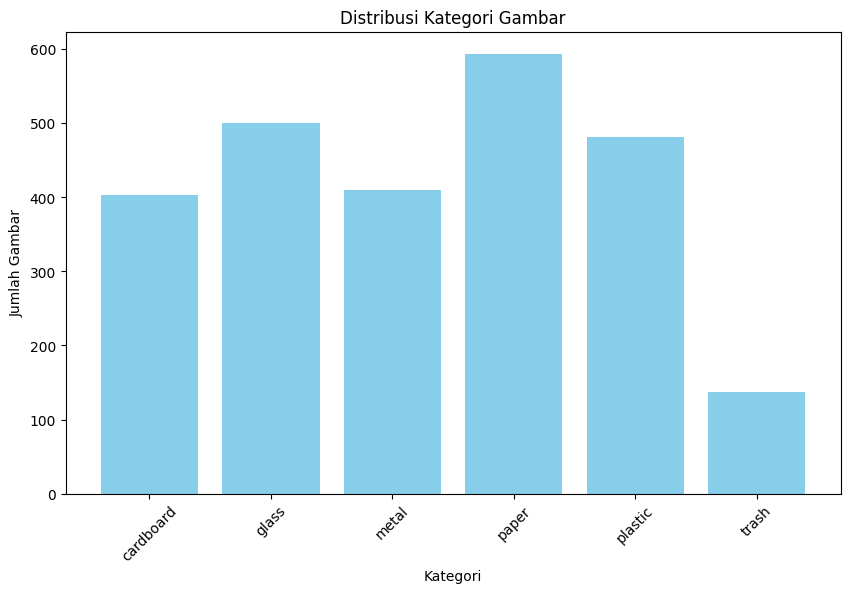

In [14]:
# Ekstrak nama kategori dari path
categories = [os.path.basename(os.path.dirname(path)) for path in ALL_IMAGES_PATHS]

# Hitung jumlah tiap kategori
category_counts = Counter(categories)

# Plot distribusi kategori sebagai bar chart
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
plt.title('Distribusi Kategori Gambar')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)
plt.show()

Dari grafik, bisa kita lihat beberapa hal penting terkait distribusi data di dataset **trashnet** ini:

1. **Ketidakseimbangan Kelas**  
   Dataset ini terlihat **imbalance** karena beberapa kelas punya jumlah sampel yang jauh lebih banyak dibanding kelas lain. Misalnya:
   - **"Paper"** memiliki jumlah sampel terbanyak, menunjukkan bahwa kelas ini mendominasi dataset.
   - **"Trash"** adalah kelas minoritas dengan jumlah sampel yang paling sedikit, membuatnya jauh di bawah kelas lain.

2. **Potensi Bias Model**  
   Ketidakseimbangan data ini berpotensi menyebabkan bias pada model saat training. Jika model dilatih pada dataset seperti ini tanpa penyesuaian, kemungkinan besar model akan lebih **cenderung mengenali kelas mayoritas** (seperti "paper") dengan akurasi lebih tinggi. Di sisi lain, model mungkin **sulit mengenali kelas dengan data sedikit** (seperti "trash"), dan ini bisa berujung pada kinerja yang buruk pada kelas tersebut.

3. **Kebutuhan Augmentasi atau Penyesuaian**  
   Mengingat perbedaan jumlah sampel antar kelas, ada baiknya kita mempertimbangkan teknik **oversampling** atau **weighted loss** saat melatih model. Misalnya:
   - **Weighted Loss Function**: Memberikan bobot lebih besar ke kelas minoritas (misalnya "trash") dalam fungsi loss dapat membantu model untuk tidak "mengabaikan" kelas tersebut selama proses training.

4. **Evaluasi dengan Metode yang Tepat**  
   Karena dataset tidak seimbang, metrik evaluasi seperti **accuracy** mungkin tidak cukup mewakili performa model secara keseluruhan. Misalnya, model bisa saja mencapai akurasi tinggi hanya dengan mengenali kelas mayoritas dengan baik, tapi gagal di kelas minoritas. Oleh karena itu, disarankan untuk memakai **precision, recall, dan F1-score** per kelas agar lebih jelas performa model di tiap kelas.

5. **Impak pada Aplikasi di Dunia Nyata**  
   Jika dataset ini digunakan untuk aplikasi nyata (misalnya, sistem klasifikasi sampah otomatis), ketidakseimbangan ini bisa mengurangi efektivitasnya. Misalnya, jika model sering gagal mengenali "trash," ini mungkin menyebabkan sampah yang sebenarnya perlu dibuang atau diolah dengan cara tertentu malah diklasifikasi salah, sehingga sistem tidak dapat bekerja optimal.

Kesimpulan
Secara keseluruhan, **grafik ini menunjukkan adanya ketidakseimbangan yang perlu diatasi** untuk memastikan model bisa mengenali semua kelas dengan baik, bukan hanya kelas mayoritas. Implementasi teknik handling imbalance seperti **augmentation pada kelas minoritas**, **weighted loss**, atau **evaluasi dengan metrik yang tepat** sangat disarankan untuk mencapai performa yang lebih adil di seluruh kelas.

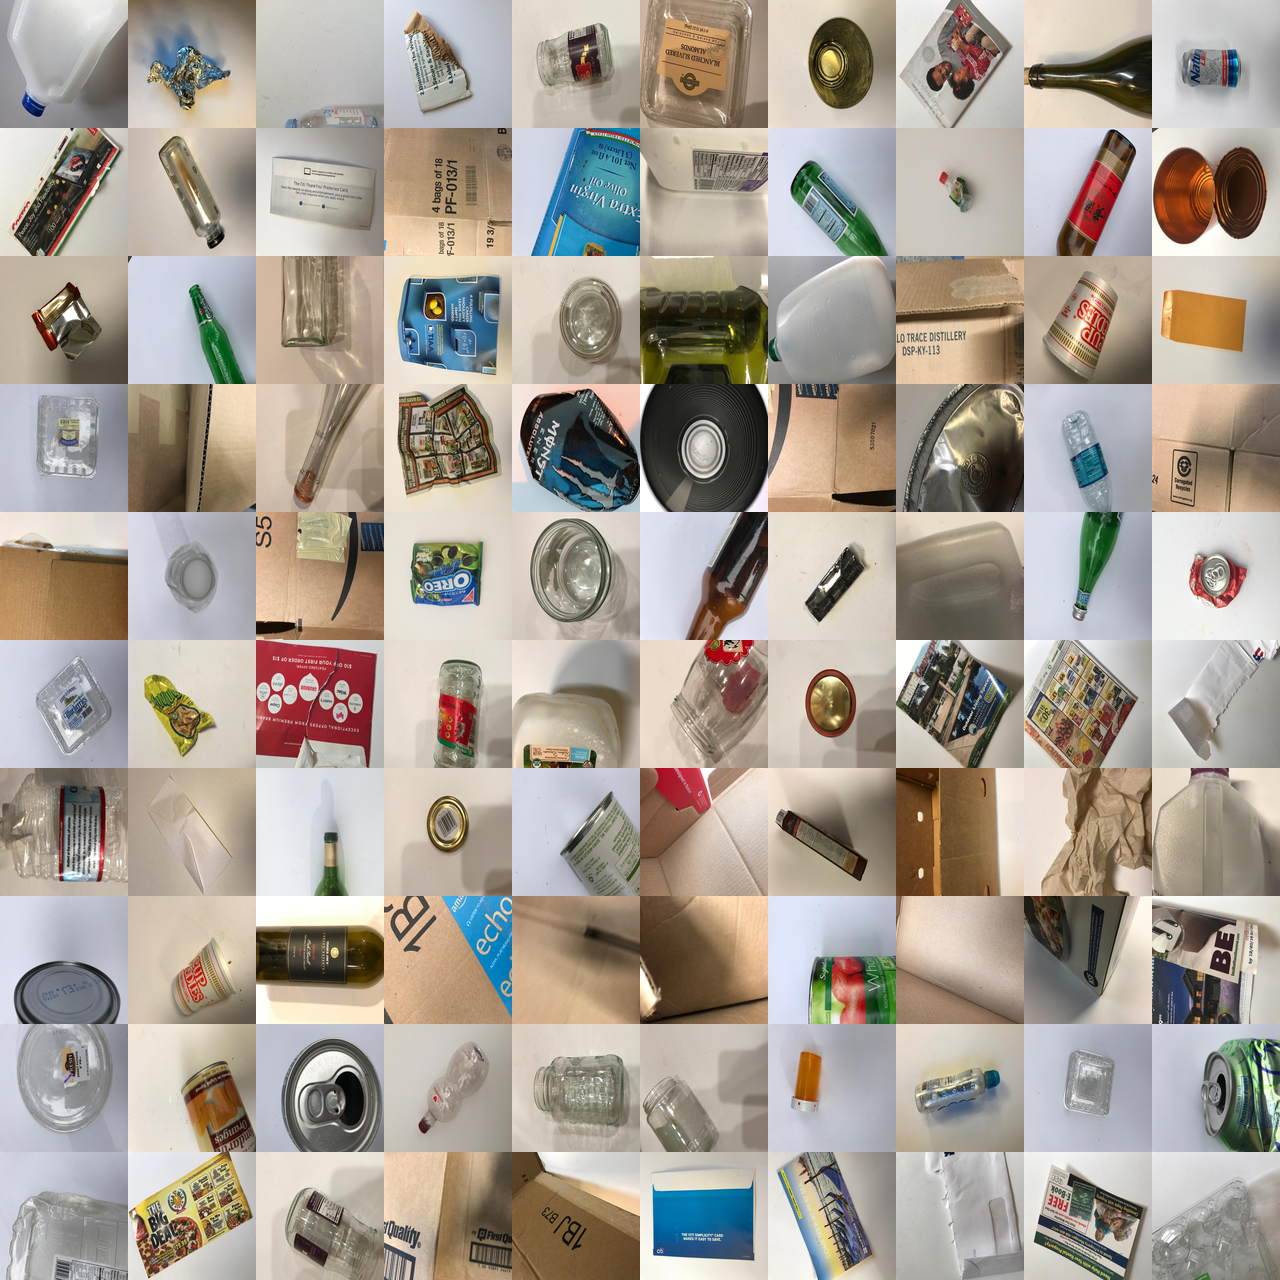

In [15]:
# Buat sprite image
num_imgs = 100
random_images = random.sample(ALL_IMAGES_PATHS, num_imgs)
sprite_image = images_to_sprite(random_images, sprite_size=(128, 128))
sprite_image

#### Mengumpulkan Jalur File dan Menampilkan Informasi File

* Pada bagian ini, kita menggunakan `tf.data.Dataset.list_files` untuk membuat dataset dari jalur file yang telah kita kumpulkan dalam variabel `ALL_IMAGES_PATHS`. Dataset ini akan berisi jalur dari setiap gambar, dan kita dapat menggunakannya untuk proses lebih lanjut, seperti memuat gambar atau menampilkan informasi file.


In [16]:
tf_paths = tf.data.Dataset.list_files(ALL_IMAGES_PATHS, shuffle=False)

In [17]:
for path in tf_paths.take(1):
  print(path)

tf.Tensor(b'..\\artifacts\\data_ingestion\\dataset-resized\\cardboard\\cardboard1.jpg', shape=(), dtype=string)


In [18]:
print(f'data: {tf_paths}')
print(f'number of data: {tf_paths.cardinality()}')

data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
number of data: 2527


Setelah itu, kita membuat sebuah objek `FilePathInfo` dengan unit ukuran file 'KB'. Objek ini digunakan untuk menampilkan informasi detail tentang file yang ada di jalur tersebut, seperti nama file, ukuran, dan ekstensi.

In [19]:
file_info  = FilePathInfo(unit_file_size='KB')

Fungsi `show_train_files_path_info` dari kelas `FilePathInfo` akan digunakan untuk menampilkan informasi tersebut secara acak dari dataset jalur file yang ada. Selain itu, kita juga mendapatkan indeks label dari file yang berisi label untuk kelas data.

In [20]:
LABEL_INDEX = file_info.show_train_files_path_info(tf_paths, is_random=True)

=================================  PATH INFO  ==================================
File Path: ..\artifacts\data_ingestion\dataset-resized\cardboard\cardboard263.jpg

==============================  SPLIT FILE PATH  ===============================
Split File Path: [b'..' b'artifacts' b'data_ingestion' b'dataset-resized' b'cardboard'
 b'cardboard263.jpg']

================================  INDEXED PATH  ================================
Index -> 0: b'..'
Index -> 1: b'artifacts'
Index -> 2: b'data_ingestion'
Index -> 3: b'dataset-resized'
Index -> 4: b'cardboard'
Index -> 5: b'cardboard263.jpg'

======================  KIND DATA INDEX DATASET-RESIZED  =======================
Index of "dataset-resized": 3

================================  INDEX LABEL  =================================
Index Label: 4

===================================  LABEL  ====================================
Label: b'cardboard'

=================================  FILE NAME  ==================================
File Name:

## Step 2. Split Data

### function

In [21]:
class DatasetSplitter:
    """
    Kelas ini digunakan untuk membagi dataset menjadi tiga bagian: training, validation, dan testing.
    Pembagian dilakukan berdasarkan rasio yang dapat dikonfigurasi, dan dataset dapat diacak sebelum dibagi.
    """

    def __init__(self):
        """
        Inisialisasi kelas `DatasetSplitter`. Tidak ada argumen yang diterima saat inisialisasi.
        """
        pass

    def split_train_valid_test(self, dataset, split_ratio=None, shuffle=True, buffer_size=None, seed=42):
        """
        Membagi dataset menjadi tiga bagian: training, validation, dan testing.

        Args:
            dataset (tf.data.Dataset): Dataset yang akan dibagi.
            train_ratio (float, optional): Rasio data untuk training. Default adalah 0.7.
            valid_ratio (float, optional): Rasio data untuk validation. Default adalah 0.2.
            shuffle (bool, optional): Apakah dataset perlu diacak sebelum pembagian. Default adalah True.
            buffer_size (int, optional): Ukuran buffer untuk pengacakan dataset. Jika None, buffer_size diambil dari ukuran dataset.
            seed (int, optional): Seed untuk pengacakan dataset. Default adalah 42.

        Returns:
            tuple: Tuple yang berisi tiga dataset yang sudah dibagi: (train_dataset, val_dataset, test_dataset).
        """

        try:
            dataset_size = len(dataset) if buffer_size is None else buffer_size

            # Define individual ratios for training, validation, and test sets
            train_ratio = split_ratio[0]
            val_ratio = split_ratio[1]
            test_ratio = round(max(1.0 - (train_ratio + val_ratio), 0), 4)  # Calculate remaining ratio for test set

            # Verify the total ratio equals 1.0; raise an error if not
            total_ratio = round(sum((train_ratio, val_ratio, test_ratio)), 2)
            if total_ratio != 1.0:
                raise ValueError("[ERROR] split_ratio must sum to 1.0.\n")

            # Determine the number of images in each split based on the calculated ratios
            train_size = int(round(dataset_size * train_ratio, 0))
            val_size = int(round(dataset_size * val_ratio, 0))
            test_size = int(round(dataset_size * test_ratio, 0))

            # Randomly shuffle the image files if random_split is enabled
            if shuffle:
                dataset = dataset.shuffle(buffer_size=dataset_size, seed=seed)

            # Split the files into training, validation, and test sets based on calculated sizes
            train_dataset = dataset.take(train_size)
            val_test_dataset = dataset.skip(train_size)

            # Jika test_size == 0, hanya buat train dan validation dataset
            if test_size == 0:
                val_dataset = val_test_dataset.take(val_size)
                self._display_info(
                    dataset=dataset,
                    train_dataset=train_dataset,
                    valid_dataset=val_dataset,
                    dataset_size=dataset_size,
                    shuffle=shuffle,
                    test_size=test_size
                )

                return train_dataset, val_dataset
            else:
                val_dataset = val_test_dataset.take(val_size)
                test_dataset = val_test_dataset.skip(val_size)

                self._display_info(
                    dataset=dataset,
                    train_dataset=train_dataset,
                    valid_dataset=val_dataset,
                    test_dataset=test_dataset,
                    dataset_size=dataset_size,
                    shuffle=shuffle,
                    test_size=test_size
                )

                return train_dataset, val_dataset, test_dataset

        except Exception as e:
            print(f"Error: {e}")
            return None, None, None

    def _display_info(self, dataset=None, train_dataset=None, valid_dataset=None, test_dataset=None, dataset_size=None, shuffle=False, test_size=None):
        """
        Menampilkan informasi mengenai pembagian dataset seperti ukuran, rasio, dan status shuffle.

        Args:
            dataset (tf.data.Dataset): Dataset asli yang belum dibagi.
            train_dataset (tf.data.Dataset): Dataset bagian training.
            valid_dataset (tf.data.Dataset): Dataset bagian validation.
            test_dataset (tf.data.Dataset): Dataset bagian testing.
            dataset_size (int): Ukuran total dataset.
            shuffle (bool): Status apakah dataset diacak sebelum dibagi.
        """
        train_ratio = len(train_dataset) / dataset_size
        valid_ratio = len(valid_dataset) / dataset_size
        test_ratio = len(test_dataset) / dataset_size if test_size > 0 else 0

        print(f"Total number of data: {dataset_size}")
        print(f"Shuffle status: {shuffle}")

        custom_title_print(' Training Dataset ')
        print(f"Info data: {train_dataset}")
        print(f"Training Split: {round(train_ratio * 100, 2)}%")
        print(f"Number of data: {len(train_dataset)}")
        print()

        custom_title_print(' Validation Dataset ')
        print(f"Info data: {valid_dataset}")
        print(f"Validation Split: {round(valid_ratio * 100, 2)}%")
        print(f"Number of data: {len(valid_dataset)}")
        print()

        if test_size > 0:
            custom_title_print(' Test Dataset ')
            print(f"Info data: {test_dataset}")
            print(f"Test Split: {round(test_ratio * 100, 2)}%")
            print(f"Number of data: {len(test_dataset)}")


In [22]:
def extract_class_from_path_tf(path_tensor):
    """
    Mengekstrak nama kelas dari jalur file yang disimpan dalam bentuk tensor.

    Args:
        path_tensor (tf.Tensor): Tensor yang berisi jalur file.

    Returns:
        tf.Tensor: Tensor yang berisi nama kelas yang diekstrak dari jalur file.
    """

    try:
        parts = tf.strings.split(path_tensor, os.path.sep)
        class_name = parts[-2]  # Nama kelas biasanya berada di posisi kedua dari belakang dalam jalur
        return class_name
    except Exception as e:
        print(f"Error: {e}")

In [23]:
def calculate_class_distribution_tf(dataset, class_labels):
    """
    Menghitung distribusi kelas dan class weight menggunakan `compute_class_weight` dari sklearn.

    Args:
        dataset (tf.data.Dataset): Dataset TensorFlow berisi gambar dan label.
        class_labels (list): Daftar nama kelas yang diurutkan (misal: ['cardboard', 'glass', ...]).

    Returns:
        tuple: class_counts (Counter), class_weights (dict)
               class_weights dalam bentuk {label_index: weight}
    """
    try:
        # Mengambil nama kelas dari path dan mengonversinya menjadi list
        class_names = dataset.map(lambda x: extract_class_from_path_tf(x))
        class_names_list = list(class_names.batch(1000).as_numpy_iterator())
        all_class_names = [name.decode('utf-8') for batch in class_names_list for name in batch]

        # Hitung distribusi kelas
        class_counts = Counter(all_class_names)

        # Konversi nama kelas ke indeks numerik sesuai `class_labels`
        class_indices = [class_labels.index(name) for name in all_class_names]

        # Hitung class weight menggunakan sklearn
        class_weight_values = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(class_indices),
            y=class_indices
        )

        # Buat dict class_weights sesuai indeks
        class_weights = {i: weight for i, weight in enumerate(class_weight_values)}

        return class_counts, class_weights

    except Exception as e:
        print(f"Error: {e}")

In [24]:
def print_class_distribution(distribution):
    """
    Mencetak distribusi kelas ke layar.

    Args:
        distribution (collections.Counter): Objek Counter yang berisi distribusi kelas.
    """
    for class_name, count in sorted(distribution.items()):
        print(f"{class_name}: {count}")

### main program

In [25]:
splitter = DatasetSplitter()

In [26]:
train_tf_paths, valid_tf_paths = splitter.split_train_valid_test(
    dataset=tf_paths,
    split_ratio=SPLIT_RATIO,
    shuffle=True,
    seed=12
)

Total number of data: 2527
Shuffle status: True
==============================  TRAINING DATASET  ==============================
Info data: <_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Training Split: 89.99%
Number of data: 2274

=============================  VALIDATION DATASET  =============================
Info data: <_TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Validation Split: 10.01%
Number of data: 253



In [27]:
for train_path, valid_path in zip(train_tf_paths.take(1), valid_tf_paths.take(1)):
    print(train_path)
    print(valid_path)

tf.Tensor(b'..\\artifacts\\data_ingestion\\dataset-resized\\paper\\paper514.jpg', shape=(), dtype=string)
tf.Tensor(b'..\\artifacts\\data_ingestion\\dataset-resized\\glass\\glass44.jpg', shape=(), dtype=string)


In [28]:
train_class_distribution, class_weights = calculate_class_distribution_tf(train_tf_paths, LABEL_LIST)
valid_class_distribution, _ = calculate_class_distribution_tf(valid_tf_paths, LABEL_LIST)

In [29]:
class_weights

{0: 1.03551912568306,
 1: 0.8348017621145375,
 2: 1.0243243243243243,
 3: 0.7137476459510358,
 4: 0.871264367816092,
 5: 3.211864406779661}

#### Menyimpan Label Encoding

In [30]:
save_object(
    file_path=CLASS_WEIGHTS_PATH,
    obj=class_weights
)

Object saved to ..\artifacts\objects\class_weights.pkl


In [31]:
custom_title_print("Class distribution on Train set:")
print_class_distribution(train_class_distribution)
print()

custom_title_print("Class distribution in Validation set:")
print_class_distribution(valid_class_distribution)
print()

======================= CLASS DISTRIBUTION ON TRAIN SET: =======================
cardboard: 366
glass: 454
metal: 370
paper: 531
plastic: 435
trash: 118

==================== CLASS DISTRIBUTION IN VALIDATION SET: =====================
cardboard: 45
glass: 45
metal: 44
paper: 47
plastic: 53
trash: 19



## Step 3. Data Preprocessing

### function

In [32]:
def show_data_info(**datasets):
    """
    Menampilkan informasi detail tentang dataset yang diberikan.

    Args:
        **datasets: Satu atau lebih dataset yang ingin ditampilkan informasi.
    """

    try:
        for dataset_name, dataset in datasets.items():
            custom_title_print(f"{dataset_name} info")
            print(f'info {dataset_name}: {dataset}')
            print(f'number of {dataset_name}: {len(dataset)}')
            print()
    except Exception as e:
        print(f'''
            explicitly input parameter names such as:
            show_data_info(train_dataset=train_ds, valid_dataset=valid_ds)
        ''')

In [33]:
def create_label_list_table(label_list, default_value=-1):
    """
    Membuat StaticHashTable untuk encoding label berdasarkan daftar label yang diberikan.

    Args:
    - label_list (list): Daftar label yang ingin di-encode.
    - default_value (int): Nilai default jika label tidak ditemukan di dalam tabel.

    Returns:
    - label_table (tf.lookup.StaticHashTable): Tabel hash untuk label encoding.
    """
    # Buat tensor dari daftar label (keys)
    keys_tensor = tf.constant(label_list)

    # Buat nilai integer yang berkaitan dengan setiap label (values)
    values_tensor = tf.range(len(label_list))

    # Inisialisasi Key-Value pairs untuk tabel hash
    table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, values_tensor)

    # Membuat StaticHashTable
    label_table = tf.lookup.StaticHashTable(table_init, default_value=default_value)

    return label_table

In [34]:
def save_images_from_dataset(dataset, output_dir, label_mapping, max_images_per_class=None):
    """
    Simpan gambar dari TensorFlow dataset ke folder berdasarkan label.

    Args:
    - dataset: TensorFlow dataset yang berisi pasangan (image, label).
    - output_dir: Path direktori utama untuk menyimpan gambar.
    - label_mapping: List yang memetakan indeks label ke nama kelas. Contoh: ['akiec', 'bcc'].
    - max_images_per_class: (Optional) Jumlah maksimum gambar yang disimpan per kelas. Jika None, simpan semua gambar.
    """

    # Buat direktori output jika belum ada
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Dictionary untuk melacak jumlah gambar yang sudah disimpan per kelas
    saved_count_per_class = {class_name: 0 for class_name in label_mapping}

    # Hitung total data jika `max_images_per_class` tidak diberikan
    total_images = {class_name: 0 for class_name in label_mapping}
    if max_images_per_class is None:
        for image, label in dataset:
            label_np = label.numpy()
            class_name = label_mapping[label_np]
            total_images[class_name] += 1

    # Iterasi setiap batch di dataset dengan looping
    for image, label in dataset:
        # Convert Tensor ke NumPy array untuk gambar dan label
        image_np = image.numpy()
        label_np = label.numpy()

        # Cari nama kelas berdasarkan label
        class_name = label_mapping[label_np]

        # Jika batas max_images_per_class tercapai untuk kelas ini, skip iterasi berikutnya
        if max_images_per_class is not None and saved_count_per_class[class_name] >= max_images_per_class:
            # Jika semua kelas sudah mencapai batas penyimpanan gambar, keluar dari loop utama
            if all(count >= max_images_per_class for count in saved_count_per_class.values()):
                print("Mencapai batas maksimum gambar per kelas, berhenti menyimpan.")
                break
            continue

        # Buat path folder untuk setiap label (kelas)
        class_folder = os.path.join(output_dir, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)  # Buat folder jika belum ada

        # Tentukan path untuk menyimpan gambar dengan urutan numerik
        saved_count_per_class[class_name] += 1
        file_name = f"{class_name}_{saved_count_per_class[class_name]}.jpg"
        file_path = os.path.join(class_folder, file_name)

        # Cek jika file sudah ada, skip
        if not os.path.exists(file_path):
            # Konversi ke uint8 dengan mengubah range dari [0, 1] ke [0, 255]
            image_np_uint8 = (image_np * 255).astype(np.uint8)

            # Gunakan image_np_uint8 untuk menyimpan gambar dengan PIL
            image_pil = Image.fromarray(image_np_uint8)
            image_pil.save(file_path)

            # Jika `max_images_per_class` tidak diberikan, gunakan jumlah total gambar sebagai progress
            total_images_class = max_images_per_class if max_images_per_class is not None else total_images[class_name]

            # Tampilkan progress bar khusus untuk kelas ini
            with tqdm(total=total_images_class, desc=f"Saving {class_name} images", unit="image", position=0, leave=False) as pbar:
                pbar.update(1)

    print(f"Gambar yang disimpan per kelas: {saved_count_per_class}")

In [35]:
class ImagePreprocessor:
    """
    Kelas ini bertanggung jawab untuk memproses gambar sebelum digunakan dalam pelatihan model.
    Ini mencakup konversi jalur file gambar menjadi gambar, mengubah ukuran gambar, normalisasi,
    dan augmentasi gambar untuk dataset pelatihan, validasi, dan pengujian.
    """

    def __init__(self, label_index, label_encoding, target_size=(200, 200), is_gray=False):
        """
        Inisialisasi kelas `ImagePreprocessor`.

        Args:
            label_index (int): Indeks jalur untuk mengambil label dari jalur gambar.
            label_encoding (tf.lookup.StaticHashTable): Objek lookup untuk mendapatkan label numerik dari nama kelas.
            target_size (tuple, optional): Ukuran target gambar yang diinginkan. Default adalah (200, 200).
            is_gray (bool, optional): Jika True, gambar akan dikonversi menjadi grayscale. Default adalah False.
        """
        self.label_index = label_index
        self.label_encoding = label_encoding
        self.target_size = target_size
        self.is_gray = is_gray
        self.channels = 1 if self.is_gray else 3

    # ===================================================================================================
    # ------------------------------------ _CONVERT_PATH_TO_IMAGE_SINGLE --------------------------------
    # ===================================================================================================

    def _convert_path_to_image_single(self, image_path):
        """
        Mengonversi jalur file gambar menjadi gambar dan label.

        Args:
            image_path (str): Jalur file gambar.

        Returns:
            tuple: Gambar yang dikonversi, label numerik, dan jalur file gambar.
        """
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels= self.channels)
        image.set_shape([None, None,  self.channels])
        split_img_path = tf.strings.split(image_path, os.path.sep)
        label = self.label_encoding.lookup(split_img_path[self.label_index])
        return image, label, image_path

    # ===================================================================================================
    # ------------------------------------ _RESIZE_IMAGE ------------------------------------------------
    # ===================================================================================================

    def _resize_image(self, image, label):
        """
        Mengubah ukuran gambar ke ukuran target yang telah ditentukan.

        Args:
            image (tf.Tensor): Gambar input.
            label (int): Label gambar.

        Returns:
            tuple: Gambar yang diubah ukurannya dan label.
        """
        image = tf.image.resize(image, size=(self.target_size[0], self.target_size[1]))
        image = tf.cast(image, tf.uint8)
        return image, label

    # ===================================================================================================
    # ------------------------------------ _NORMALIZE_IMAGE ---------------------------------------------
    # ===================================================================================================

    def _normalize_image(self, image, label):
        """
        Melakukan normalisasi gambar dengan membagi nilai pixel dengan 255.

        Args:
            image (tf.Tensor): Gambar input.
            label (int): Label gambar.

        Returns:
            tuple: Gambar yang dinormalisasi dan label.
        """
        image = tf.cast(image, tf.float32)
        image = image / 255.0
        label = tf.cast(label, tf.int32)
        return image, label

    # ===================================================================================================
    # ------------------------------------ _AUGMENT_IMAGE -----------------------------------------------
    # ===================================================================================================

    def _augment_image(self, image, label=None):
        """
        Melakukan augmentasi pada gambar, termasuk flipping horizontal dan vertikal serta rotasi 90 atau -90 derajat.

        Args:
            image (tf.Tensor): Gambar input.
            label (int, optional): Label gambar.

        Returns:
            tuple: Gambar yang telah diaugmentasi dan label (jika ada).
        """

        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.)
        return image, label


    # ===================================================================================================
    # ------------------------------------ _APPLY_CONVERT_PATH_TO_IMAGE ---------------------------------
    # ===================================================================================================

    def _apply_convert_path_to_image(self, dataset):
        """
        Melakukan konversi jalur file ke gambar untuk dataset tertentu.

        Args:
            dataset (tf.data.Dataset): Dataset jalur file gambar.

        Returns:
            tf.data.Dataset: Dataset gambar yang dikonversi dari jalur file.
        """
        return dataset.map(
            map_func=lambda image_path: self._convert_path_to_image_single(image_path),
            num_parallel_calls=tf.data.AUTOTUNE
        ).cache()

    # ===================================================================================================
    # ------------------------------------ _APPLY_IMAGE_RESIZING ----------------------------------------
    # ===================================================================================================

    def _apply_image_resizing(self, dataset):
        """
        Mengubah ukuran gambar pada dataset tertentu.

        Args:
            dataset (tf.data.Dataset): Dataset gambar.

        Returns:
            tf.data.Dataset: Dataset gambar yang sudah diubah ukurannya.
        """
        return dataset.map(
            map_func=lambda image, label, path: self._resize_image(image, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # ===================================================================================================
    # ------------------------------------ _APPLY_IMAGE_NORMALIZATION -----------------------------------
    # ===================================================================================================

    def _apply_image_normalization(self, dataset):
        """
        Melakukan normalisasi gambar pada dataset tertentu.

        Args:
            dataset (tf.data.Dataset): Dataset gambar.

        Returns:
            tf.data.Dataset: Dataset gambar yang sudah dinormalisasi.
        """
        return dataset.map(
            map_func=lambda image, label: self._normalize_image(image, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # ===================================================================================================
    # ------------------------------------ _APPLY_IMAGE_AUGMENTATION ------------------------------------
    # ===================================================================================================

    def _apply_image_augmentation(self, dataset):
        """
        Melakukan augmentasi gambar pada dataset tertentu.

        Args:
            dataset (tf.data.Dataset): Dataset gambar.

        Returns:
            tf.data.Dataset: Dataset gambar yang sudah diaugmentasi.
        """
        return dataset.map(
            map_func=lambda image, label: self._augment_image(image, label),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # ===================================================================================================
    # ------------------------------------ CONVERT_PATH_TO_IMAGE ----------------------------------------
    # ===================================================================================================
    def convert_path_to_image(self, **datasets):
        """
        """
        return (self._apply_convert_path_to_image(dataset) for dataset in datasets.values())


    # ===================================================================================================
    # ----------------------------------------- IMAGE_RESIZING ------------------------------------------
    # ===================================================================================================
    def image_resizing(self, **datasets):
        """
        """
        return (self._apply_image_resizing(dataset) for dataset in datasets.values())


    # ===================================================================================================
    # ------------------------------------ IMAGE_NORMALIZATION ------------------------------------------
    # ===================================================================================================
    def image_normalization(self, **datasets):
        """
        """
        return (self._apply_image_normalization(dataset) for dataset in datasets.values())

    # ===================================================================================================
    # ------------------------------------ IMAGE_AUGMENTATION--------------------------------------------
    # ===================================================================================================
    def image_augmentation(self, **datasets):
        """
        """
        return (self._apply_image_augmentation(dataset) for dataset in datasets.values())

In [36]:
class DataInspector:
    """
    Kelas `DataInspector` bertanggung jawab untuk melakukan inspeksi dan visualisasi
    gambar dalam dataset pelatihan, validasi, dan pengujian.
    """

    def __init__(self, label_encoding, figsize):
        """
        Inisialisasi kelas `DataInspector`.

        Args:
            label_encoding (dict): Mapping dari label numerik ke label kelas.
            figsize (tuple): Ukuran figure untuk plot visualisasi gambar.
        """
        self.label_encoding = label_encoding
        self.figsize = figsize

    def _custom_title_print(self, title, n_strip=80):
        """
        Menampilkan judul yang diformat khusus dengan tanda pemisah.

        Args:
            title (str): Judul yang akan ditampilkan.
            n_strip (int, optional): Jumlah karakter untuk garis pemisah. Default adalah 80.
        """
        print('=' * n_strip)
        print(f' {title.upper()} '.center(n_strip, '='))
        print('=' * n_strip)

    def _inspect_single_dataset(self, dataset, ds_name, ispath, idx):
        """
        Helper function untuk menginspeksi dataset tertentu.

        Args:
            dataset (tf.data.Dataset): Dataset yang akan diinspeksi.
            ds_name (str): Nama dataset (train, valid, test).
            idx (int, optional): Indeks untuk memulai pengambilan contoh gambar. Default 1.
        """

        plt.figure(figsize=self.figsize)

        if ispath:
            for i, (image, label, path) in enumerate(dataset.skip(idx).take(1), 1):
                self._print_data_info(f"{ds_name}_data info", image, label, path)
                self._plot_images(ds_name, image, label)
        else:
            for i, (image, label) in enumerate(dataset.skip(idx).take(1), 1):
                self._print_data_info(f"{ds_name}_data info", image, label)
                self._plot_images(ds_name, image, label)
        plt.show()

    def _print_data_info(self, title, image, label, image_path=None):
        """
        Menampilkan informasi mendetail tentang gambar dan label.

        Args:
            title (str): Judul informasi yang akan ditampilkan.
            image (tf.Tensor): Gambar yang diinspeksi.
            label (int): Label gambar yang diinspeksi.
            image_path (str, optional): Jalur file gambar (jika ada). Default adalah None.
        """
        print('\n\n')
        self._custom_title_print(title)

        if image_path is not None:
            print(f'image path: {image_path}')

        print(f'shape-image: {image.shape}')
        print(f'dtype-image: {image.dtype}')
        print(f'max-intensity: {tf.reduce_max(image)}')
        print(f'min-intensity: {tf.reduce_min(image)}')

        print(f'label: {label} -> {self.label_encoding[label.numpy()]}')
        print(f'label-shape: {label.shape}')
        print(f'label-type: {label.dtype}')
        print()

    def _plot_images(self, ds_name, image, label):
        """
        Memvisualisasikan gambar dari dataset pelatihan, validasi, dan pengujian secara dinamis.

        Args:
            datasets (dict): Dataset yang ingin di-plot (train_image, valid_image, test_image).
        """
        plt.title(f'{ds_name.capitalize()} Label: {self.label_encoding[label.numpy()]}')
        plt.imshow(image.numpy(), cmap='gray')
        plt.axis("off")

    def inspect(self, ispath=False, idx=1, **datasets):
        """
        Menginspeksi gambar dari dataset pelatihan, validasi, atau pengujian (atau gabungan).

        Args:
            datasets (dict): Dataset yang ingin diinspeksi (train_ds, valid_ds, test_ds).
                             Bisa masukkan satu atau lebih.
        """
        # Looping dinamis sesuai dataset yang diberikan (train, valid, test)
        for ds_name, ds in datasets.items():
            self._inspect_single_dataset(ds, ds_name, ispath, idx)

### main program

In [37]:
print(LABEL_LIST)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [38]:
LABEL_TABLE = create_label_list_table(LABEL_LIST, default_value=-1)
LABEL_TABLE.lookup(tf.constant('paper'))

<tf.Tensor: shape=(), dtype=int32, numpy=3>

#### Inisialisasi objek `ImagePreprocessor` dan `DataInspector`

1. `ImagePreprocessor`: Objek ini digunakan untuk melakukan preprocessing pada dataset, termasuk mengkonversi path gambar menjadi image, meresize image, normalisasi, dan augmentasi.
  - `label_index`: Indeks label dalam path file yang digunakan untuk mencari label pada gambar.
  - `label_list`: Lookup table yang digunakan untuk menerjemahkan label dari bentuk numerik ke label kelas.
  - `target_size`: Ukuran target gambar (width, height) setelah resize.

2. `DataInspector`: Digunakan untuk melakukan inspeksi dataset dan menampilkan gambar beserta informasinya.
  - `LABEL_LIST`: Lookup table yang digunakan oleh `DataInspector` untuk menerjemahkan label numerik menjadi label kelas.
  - `figsize`: Ukuran untuk visualisasi gambar dalam format subplot.


In [39]:
preprocessor = ImagePreprocessor(
    label_index=LABEL_INDEX,
    label_encoding=LABEL_TABLE,
    target_size=IMAGE_SIZE
)

inspector = DataInspector(
    LABEL_LIST,
    figsize=(12,6)
)

#### Mengkonversi path gambar ke dalam format image menggunakan objek `ImagePreprocessor`

Fungsi `convert_path_to_image` digunakan untuk mengubah path gambar dari dataset pelatihan, validasi, dan pengujian ke dalam bentuk image dan label yang dapat digunakan oleh TensorFlow.

Output dari fungsi ini adalah dataset yang sudah dalam format (image, label, path).
- `train_tf_paths`, `valid_tf_paths`, dan `test_tf_paths` merupakan dataset yang berisi path gambar dari dataset pelatihan, validasi, dan pengujian.
- Fungsi `convert_path_to_image` akan memproses masing-masing dataset ini dan mengembalikan gambar yang siap untuk dilatih, divalidasi, atau diuji.


In [40]:
train_tf_images, valid_tf_images = preprocessor.convert_path_to_image(
    train_data=train_tf_paths,
    valid_data=valid_tf_paths,
)

In [41]:
show_data_info(
    train_dataset=train_tf_images,
    valid_dataset=valid_tf_images,
)

============================== TRAIN_DATASET INFO ==============================
info train_dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
number of train_dataset: 2274

============================== VALID_DATASET INFO ==============================
info valid_dataset: <CacheDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
number of valid_dataset: 253






=========================== TRAIN_DATASET_DATA INFO ============================
image path: b'..\\artifacts\\data_ingestion\\dataset-resized\\paper\\paper210.jpg'
shape-image: (384, 512, 3)
dtype-image: <dtype: 'uint8'>
max-intensity: 255
min-intensity: 0
label: 3 -> paper
label-shape: ()
label-type: <dtype: 'int32'>



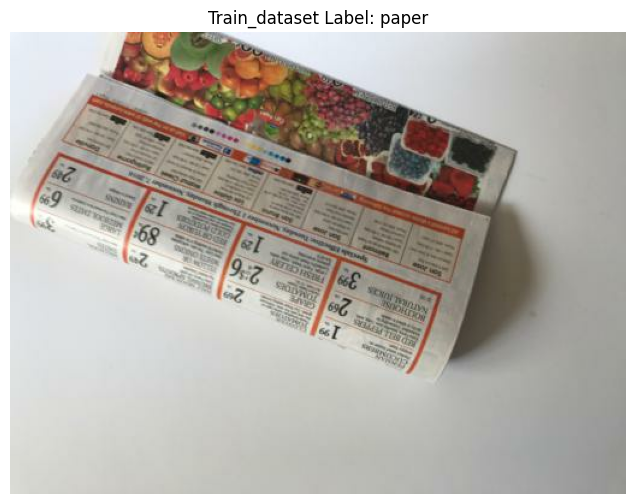




=========================== VALID_DATASET_DATA INFO ============================
image path: b'..\\artifacts\\data_ingestion\\dataset-resized\\cardboard\\cardboard132.jpg'
shape-image: (384, 512, 3)
dtype-image: <dtype: 'uint8'>
max-intensity: 247
min-intensity: 0
label: 0 -> cardboard
label-shape: ()
label-type: <dtype: 'int32'>



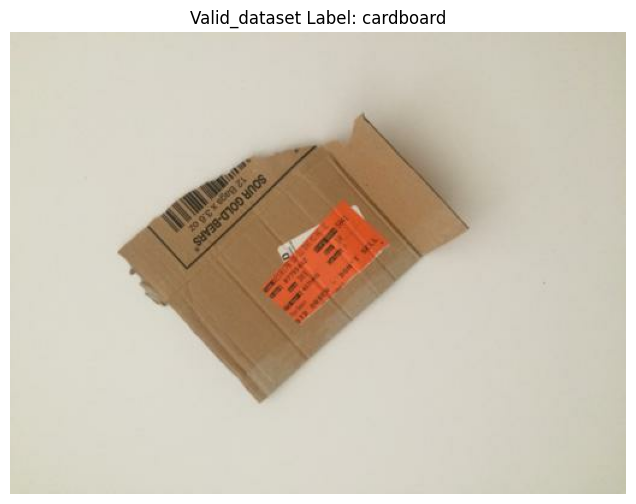

In [42]:
# Inspeksi data pada index tertentu
inspector.inspect(
    ispath=True,
    idx=1,
    train_dataset=train_tf_images,
    valid_dataset=valid_tf_images,
)

##### Cek apakah hasil gambar di atas dengan label sudah sesuai berdasarkan path

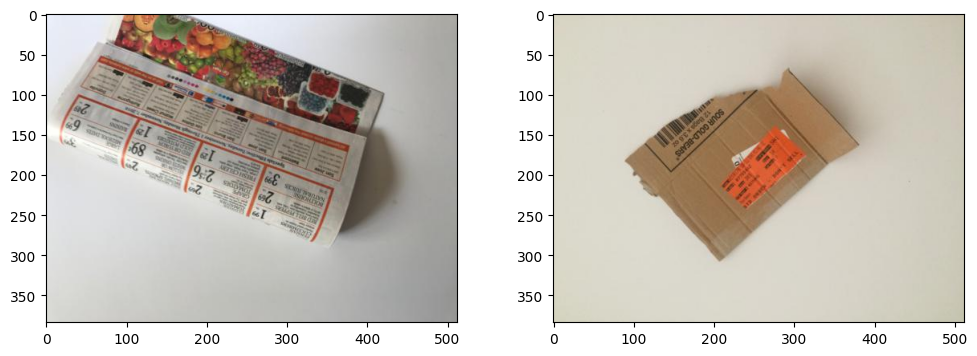

In [43]:
train_image = Image.open(f'{TRAIN_PATH}/paper/paper210.jpg')
valid_image = Image.open(f'{TRAIN_PATH}/cardboard/cardboard132.jpg')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(train_image)

plt.subplot(1, 2, 2)
plt.imshow(valid_image)

plt.show()

#### Image Resizing

In [44]:
train_tf_images_resized, valid_tf_images_resized = preprocessor.image_resizing(
    train_data=train_tf_images,
    valid_data=valid_tf_images,
)

In [45]:
show_data_info(
    train_dataset=train_tf_images_resized,
    valid_dataset=valid_tf_images_resized
)

============================== TRAIN_DATASET INFO ==============================
info train_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train_dataset: 2274

============================== VALID_DATASET INFO ==============================
info valid_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of valid_dataset: 253






=========================== TRAIN_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'uint8'>
max-intensity: 255
min-intensity: 11
label: 1 -> glass
label-shape: ()
label-type: <dtype: 'int32'>



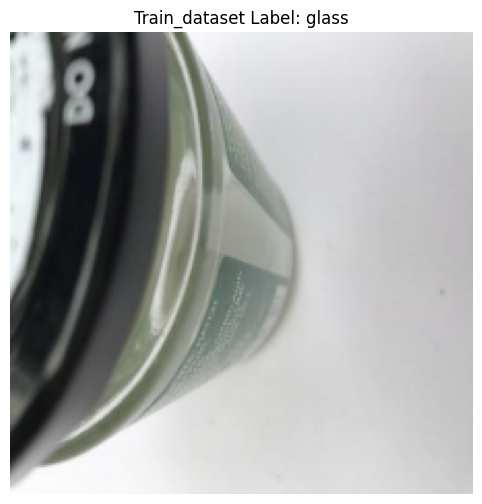




=========================== VALID_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'uint8'>
max-intensity: 247
min-intensity: 0
label: 4 -> plastic
label-shape: ()
label-type: <dtype: 'int32'>



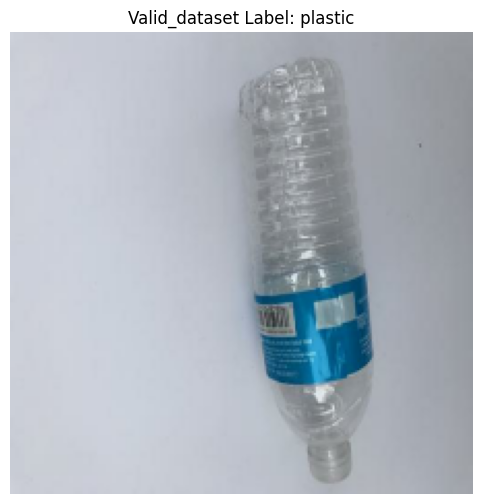

In [46]:
# Inspeksi data pada index tertentu
inspector.inspect(
    train_dataset=train_tf_images_resized,
    valid_dataset=valid_tf_images_resized
)

#### Image Normalisasi

In [47]:
train_tf_images_normalized, valid_tf_images_normalized = preprocessor.image_normalization(
    train_data=train_tf_images_resized,
    valid_data=valid_tf_images_resized,
)

In [48]:
show_data_info(
    train_dataset=train_tf_images_normalized,
    valid_dataset=valid_tf_images_normalized
)

============================== TRAIN_DATASET INFO ==============================
info train_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train_dataset: 2274

============================== VALID_DATASET INFO ==============================
info valid_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of valid_dataset: 253






=========================== TRAIN_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 1.0
min-intensity: 0.0313725508749485
label: 3 -> paper
label-shape: ()
label-type: <dtype: 'int32'>



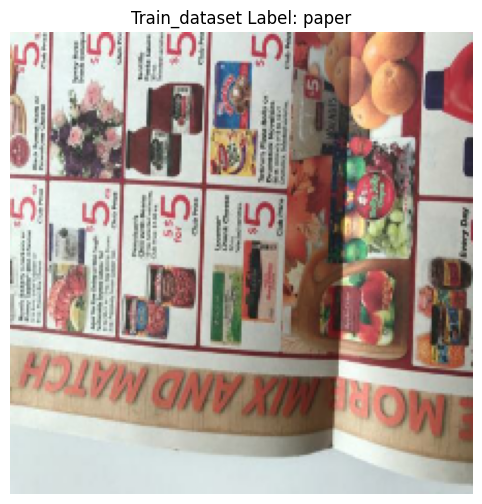




=========================== VALID_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 0.9764705896377563
min-intensity: 0.027450980618596077
label: 0 -> cardboard
label-shape: ()
label-type: <dtype: 'int32'>



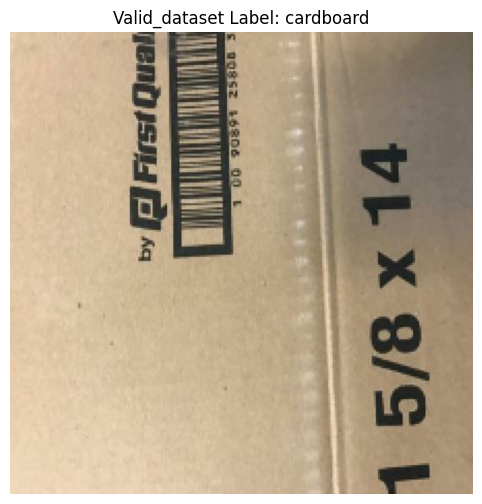

In [49]:
# Inspeksi data pada index tertentu
inspector.inspect(
    train_dataset=train_tf_images_normalized,
    valid_dataset=valid_tf_images_normalized
)

#### Image Augmentation

In [50]:
train_tf_images_augmented, valid_tf_images_augmented = preprocessor.image_augmentation(
    train_data=train_tf_images_normalized,
    valid_data=valid_tf_images_normalized
)

In [51]:
show_data_info(
    train_dataset=train_tf_images_augmented,
    valid_dataset=valid_tf_images_augmented
)

============================== TRAIN_DATASET INFO ==============================
info train_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train_dataset: 2274

============================== VALID_DATASET INFO ==============================
info valid_dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of valid_dataset: 253






=========================== TRAIN_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 0.5015726089477539
min-intensity: 0.13169869780540466
label: 1 -> glass
label-shape: ()
label-type: <dtype: 'int32'>



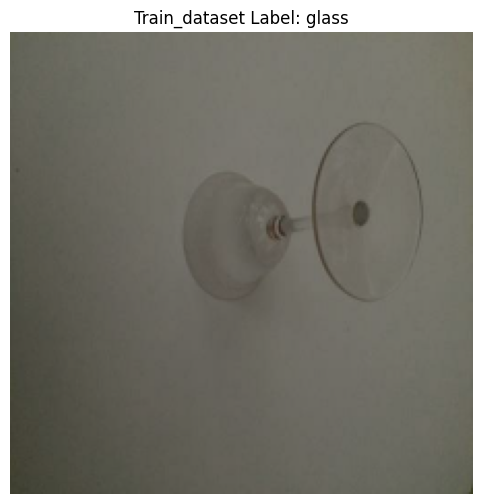




=========================== VALID_DATASET_DATA INFO ============================
shape-image: (224, 224, 3)
dtype-image: <dtype: 'float32'>
max-intensity: 0.9573780298233032
min-intensity: 0.0
label: 1 -> glass
label-shape: ()
label-type: <dtype: 'int32'>



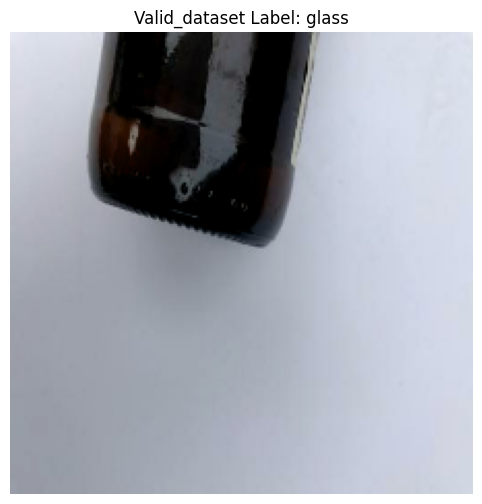

In [52]:
# Inspeksi data pada index tertentu
inspector.inspect(
    train_dataset=train_tf_images_augmented,
    valid_dataset=valid_tf_images_augmented
)

##### Apakah data dapat teraugmentasi dengan menggunakan class preprocessor

In [53]:
# Konversi gambar PIL ke tensor TensorFlow
def convert_to_tensor(image):
    image = np.array(image)
    image = tf.cast(image / 255., tf.float32)
    return image

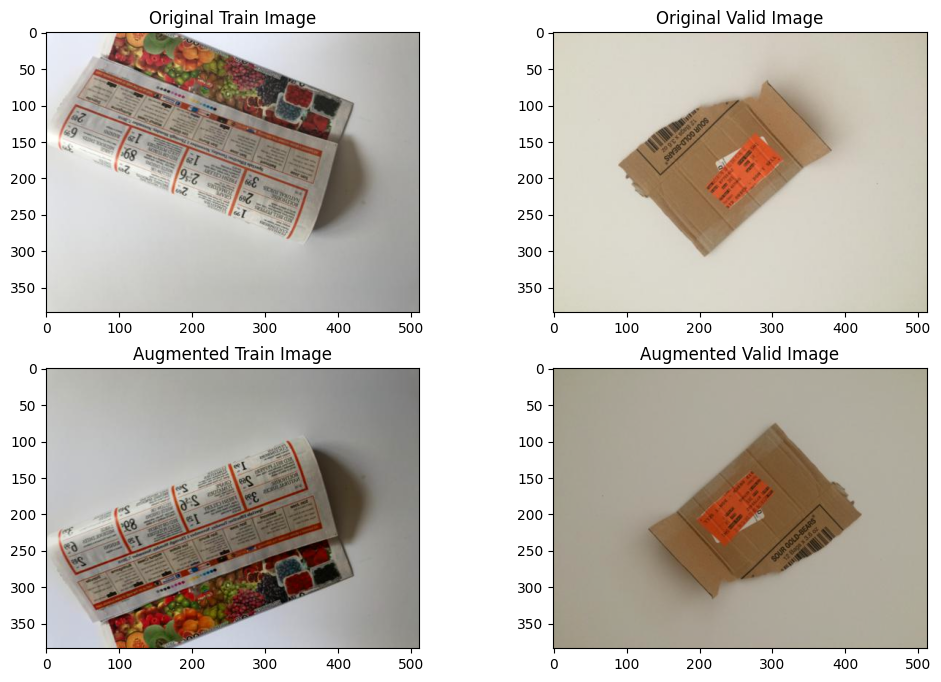

In [54]:
sample_train_image_tensor = convert_to_tensor(train_image)
sample_valid_image_tensor = convert_to_tensor(valid_image)

# Augmentasi gambar
augmented_train_image, _ = preprocessor._augment_image(sample_train_image_tensor)
augmented_valid_image, _ = preprocessor._augment_image(sample_valid_image_tensor)


# Plot gambar asli dan hasil augmentasi
plt.figure(figsize=(12, 8))

# Gambar asli
plt.subplot(2, 2, 1)
plt.title('Original Train Image')
plt.imshow(train_image)

plt.subplot(2, 2, 2)
plt.title('Original Valid Image')
plt.imshow(valid_image)

# Gambar augmentasi
plt.subplot(2, 2, 3)
plt.title('Augmented Train Image')
plt.imshow(augmented_train_image)

plt.subplot(2, 2, 4)
plt.title('Augmented Valid Image')
plt.imshow(augmented_valid_image)


plt.show()

## Step 4. Quality Check (Optional)

### function

In [55]:
def show_multiple_images_in_tf_data(dataset, n_skip, num_images, figsize_per_image=(3, 3), classes_list=None):
    """
    Menampilkan beberapa gambar dari dataset TensorFlow dalam bentuk grid.

    Args:
        dataset (tf.data.Dataset): Dataset TensorFlow yang berisi gambar dan label.
        n_skip (int): Jumlah elemen yang akan dilewati sebelum mengambil gambar untuk ditampilkan.
        num_images (int): Jumlah gambar yang ingin ditampilkan.
        figsize_per_image (tuple, optional): Ukuran setiap gambar dalam plot. Default adalah (3, 3).
        classes_list (list, optional): Daftar nama kelas yang digunakan untuk memberi judul pada gambar.
                                       Harus memiliki panjang yang sama dengan jumlah kelas yang ada dalam dataset.

    Returns:
        None: Fungsi ini hanya menampilkan gambar dan tidak mengembalikan nilai.

    Notes:
        - Jika dataset berisi pasangan (image, label), label akan digunakan untuk memberi judul pada gambar.
        - Jika dataset hanya berisi gambar, judul tidak akan ditampilkan.
        - Fungsi ini akan mengabaikan gambar yang memiliki lebih dari dua dimensi dengan cara mengurangi dimensi tambahan jika ada.
        - Ukuran dari keseluruhan grid ditentukan berdasarkan jumlah gambar yang akan ditampilkan, sehingga akan terorganisir dalam beberapa baris dan kolom.
    """
    dataset = dataset.skip(n_skip).take(num_images)

    num_columns = math.ceil(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_columns)
    figsize = (num_columns * figsize_per_image[0], num_rows * figsize_per_image[1])

    plt.figure(figsize=figsize)

    for idx, data in enumerate(dataset):
        if len(data) == 2:
            image, label = data
        else:
            image = data
            label = None

        image = image.numpy()

        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)

        plt.subplot(num_rows, num_columns, idx + 1)
        plt.imshow(np.squeeze(image), cmap='gray')

        if label is not None:
            plt.title(classes_list[label])
        plt.axis('off')

    plt.show()


### main program

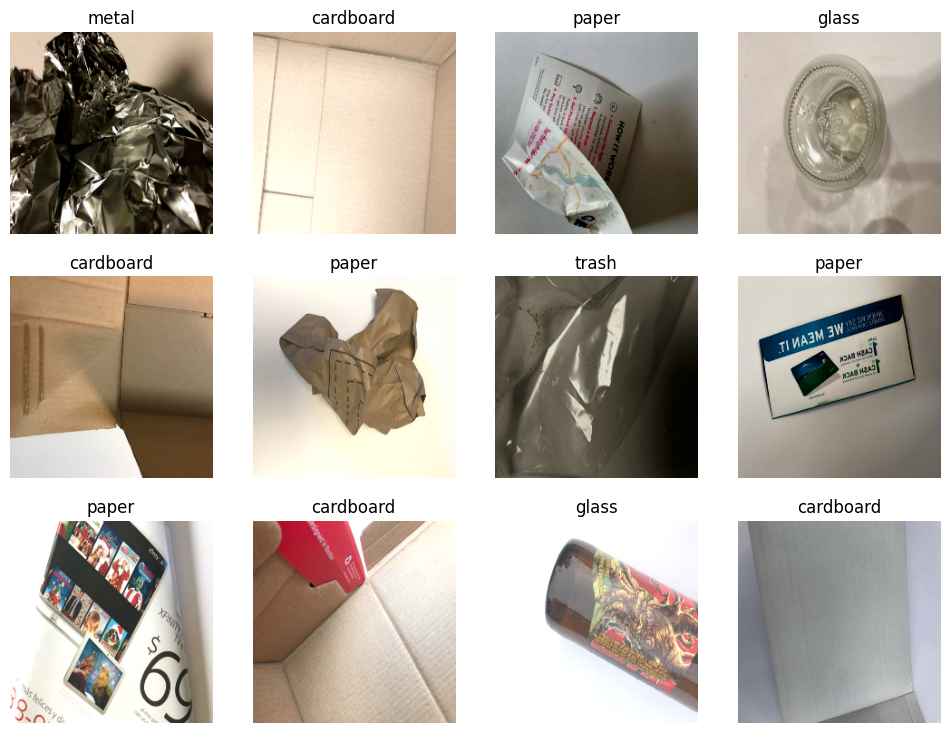

In [56]:
show_multiple_images_in_tf_data(
    train_tf_images_augmented,
    n_skip=1,
    num_images=12,
    classes_list=LABEL_LIST
)

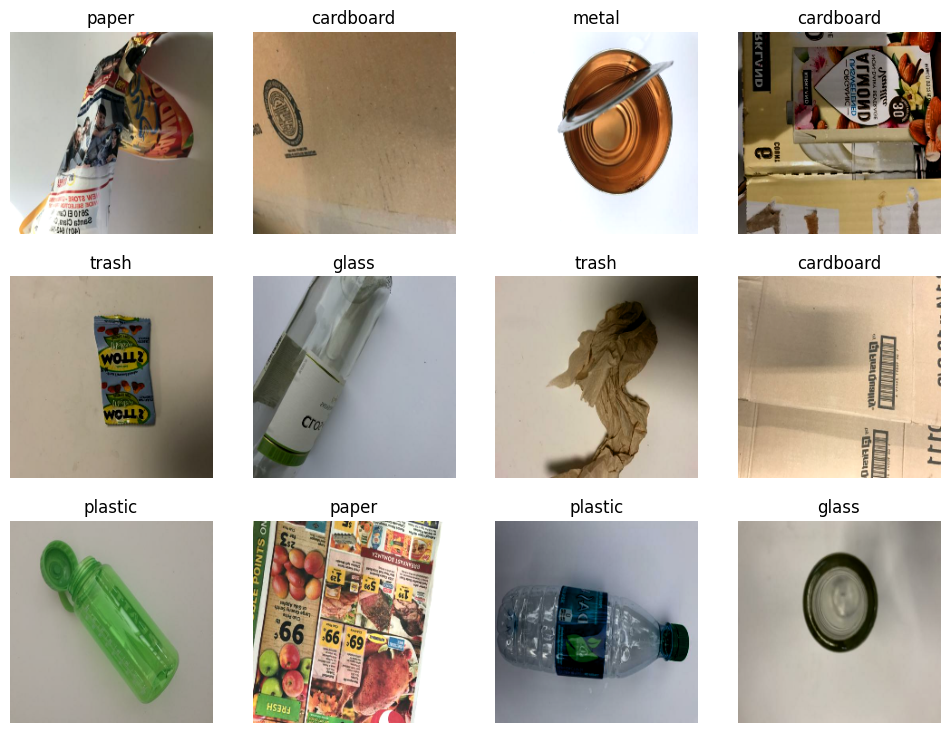

In [57]:
show_multiple_images_in_tf_data(
    valid_tf_images_augmented,
    n_skip=80,
    num_images=12,
    classes_list=LABEL_LIST
)

# SAVING DATA

Proses ini kemungkinan akan memakan waktu lama, tergantun jumlah data dan dimensi gambar atau fitur.

In [58]:
train_tf_images_augmented = train_tf_images_augmented.cache()
valid_tf_images_augmented = valid_tf_images_augmented.cache()

In [59]:
train_tf_images_augmented.save(TRAIN_TFRECOARD_PATH, compression="GZIP")
valid_tf_images_augmented.save(VALID_TFRECORD_PATH, compression="GZIP")